# Automating Contract Review With Transformer Models

##### Task 1: Import the Libraries

In [1]:
import json
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


##### Task 2: Generate Dataset Files

In [2]:
# Write convert_json_to_csv() function.
def convert_json_to_csv(json_dir,filename,count):
    with open(json_dir, 'r') as f:
        data = json.load(f)
    text_list, hypothesis_list, labels_list = [],[],[]
    counter = 0
    for doc in data['documents']:
            annotation_sets= doc.get('annotation_sets',[])
            for annotation_s in annotation_sets:
                annotations = annotation_s.get('annotations',[])
                for annotation in annotations:
                    if counter >= count:
                        break
                    if isinstance(annotations[annotation],dict):
                        if 'choice' in annotations[annotation]:
                            labels_list.append(annotations[annotation]['choice'])
                            text_list.append(doc['text'])
                            hypothesis_list.append(data['labels'][annotation]['hypothesis'])
                            counter+=1
    if len(text_list)== len(hypothesis_list) and len(hypothesis_list) ==len(labels_list):
            df = pd.DataFrame({
                'text': text_list,
                'hypothesis': hypothesis_list,
                'labels' : labels_list,
            })
            df.to_csv(filename,index= False)

    

In [3]:
# Call convert_json_to_csv() function for training, validation and testing.
directory_path = '/usercode/Contract-nli Dataset/'
train_filename = 'train_df.csv'
val_filename = 'valid_df.csv'
testing_filename = 'test_df.csv'
convert_json_to_csv(directory_path+'train.json',directory_path+train_filename,count =35)
convert_json_to_csv(directory_path+'valid.json',directory_path+val_filename, count = 10)
convert_json_to_csv(directory_path+'test.json',directory_path+testing_filename ,count = 5)


##### Task 3: Calculate Dataset Statistics

In [4]:
# 1. Load the dataset
train_df = pd.read_csv(directory_path+train_filename)
test_df = pd.read_csv(directory_path+testing_filename)
val_df = pd.read_csv(directory_path+val_filename)
train_df.head(
    
)
test_df.head()
val_df.head()


,text,hypothesis,labels
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction


In [5]:
# 2. Display the first and last 5 rows of the training dataset
train_df.tail(5)

,text,hypothesis,labels
30,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party shall notify Disclosing Party ...,Entailment
31,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party may acquire information simila...,Entailment
32,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party may share some Confidential In...,Contradiction
33,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party shall not use any Confidential...,Entailment
34,Mutual Non-Disclosure and Use of Information A...,Receiving Party shall not reverse engineer any...,NotMentioned


In [6]:
# 3. Display the dimension of the training data
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(35, 3)
(5, 3)
(10, 3)


In [7]:
# 4. Display a summary of the training DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        35 non-null     object
 1   hypothesis  35 non-null     object
 2   labels      35 non-null     object
dtypes: object(3)
memory usage: 968.0+ bytes


In [8]:
# 5. Print the statistical summary of the training, validation, and testing DataFrames
print(train_df.describe(include='all'))
print(val_df.describe(include='all'))
print(test_df.describe(include='all'))

                                                     text  \
count                                                  35   
unique                                                  3   
top     NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
freq                                                   17   

                                               hypothesis      labels  
count                                                  35          35  
unique                                                 17           3  
top     Receiving Party shall not reverse engineer any...  Entailment  
freq                                                    3          18  
                                                     text  \
count                                                  10   
unique                                                  1   
top     OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
freq                                                   10   

                            

##### Task 4: Create Visualization Function for Features

In [9]:
# Write visualize_features() function
def visualize_features(dataset,datatype,col_name,target):
    doc_length = dataset[col_name].apply(len)
    avg_length = doc_length.mean()
    min_doc_length = doc_length.min()
    max_doc_length = doc_length.max()
    median_doc = doc_length.median()
    print("Median: ", median_doc)
    print("Max : ", max_doc_length)
    print("Min : ", min_doc_length)
    print("Average: ", avg_length)
    plt.hist(doc_length, bins  = 50)
    plt.title(f"Distribution of {target} Lengths for {datatype}")
    plt.xlabel(f"{target} Length (character)")
    plt.ylabel("Count")
    plt.show()


Median:  90.0
Max :  162
Min :  66
Average:  97.6


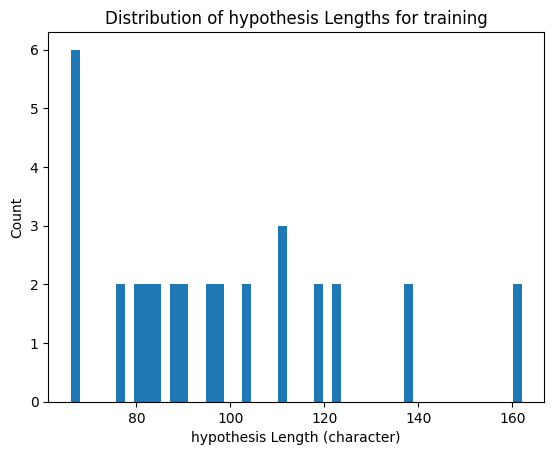

Median:  84.0
Max :  112
Min :  66
Average:  89.2


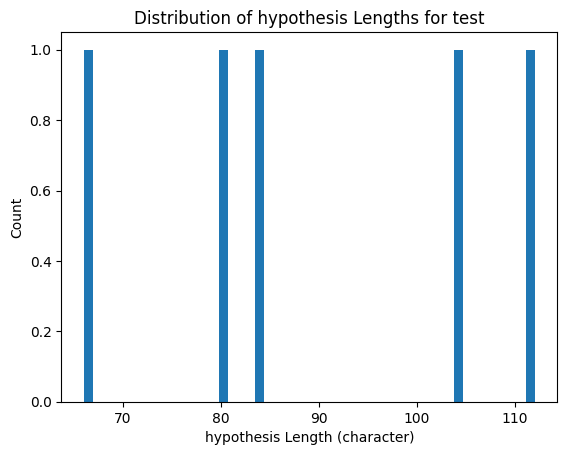

Median:  83.5
Max :  122
Min :  66
Average:  87.5


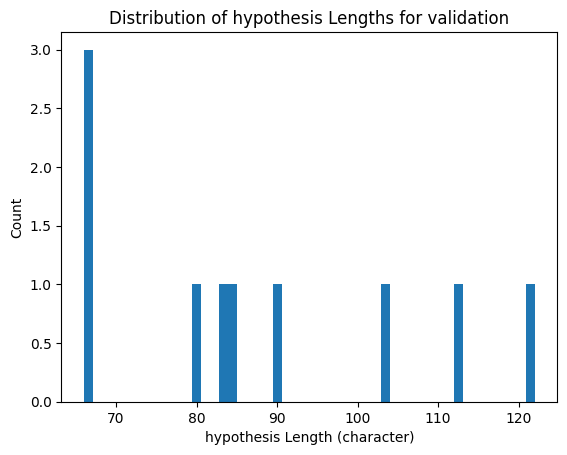

In [10]:
# Call visualize_features() function for training, validation and testing
visualize_features(train_df,'training','hypothesis','hypothesis')
visualize_features(test_df,'test','hypothesis','hypothesis')
visualize_features(val_df,'validation','hypothesis','hypothesis')



##### Task 5: Create Visualizations Function for Labels

In [11]:
# Write visualize_label() function
def visalize_label(dataset,datatype):
    print(f"Visalizing labels for {datatype}")
    label_count = dataset['labels'].value_counts()
    print(label_count)
    plt.bar(label_count.index,label_count.values)
    plt.show()

Visalizing labels for Training
labels
Entailment       18
NotMentioned     13
Contradiction     4
Name: count, dtype: int64


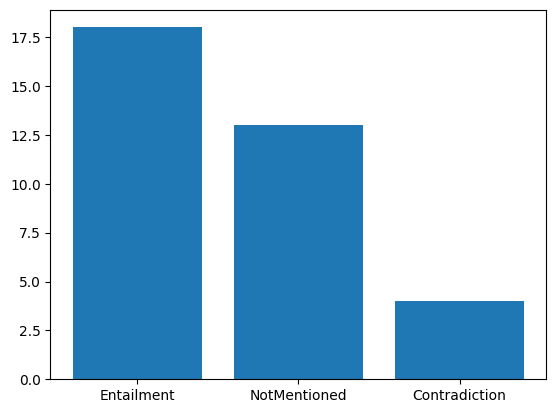

Visalizing labels for Testing
labels
NotMentioned     2
Entailment       2
Contradiction    1
Name: count, dtype: int64


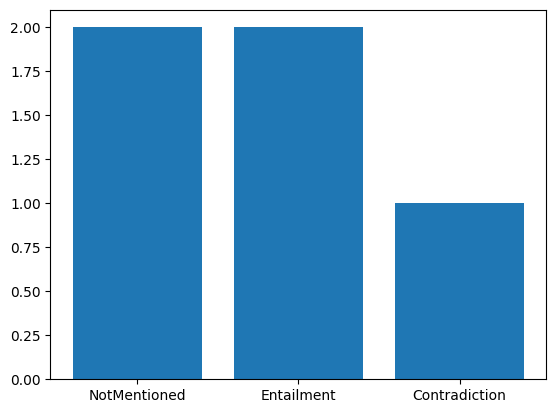

Visalizing labels for Validation
labels
Entailment       9
Contradiction    1
Name: count, dtype: int64


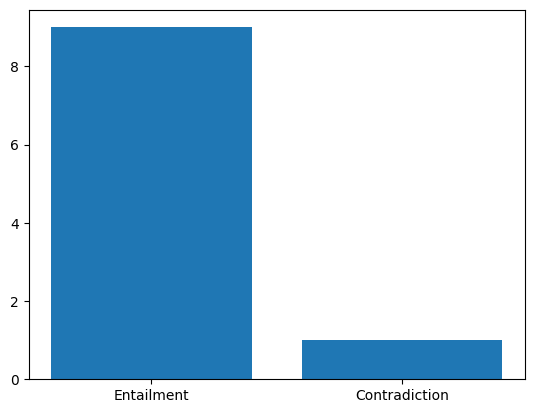

In [12]:
# Call visualize_label() function for training, validation and testing.
visalize_label(train_df,'Training')
visalize_label(test_df,'Testing')
visalize_label(val_df,'Validation')

##### Task 6: Load the Tokenizer and Model

In [13]:
# ALBERT tokenizer and model
albert_model_name = "albert-base-v2"
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)
albert_classifier = AutoModelForSequenceClassification.from_pretrained(albert_model_name,num_labels= 3)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# DistilBERT tokenizer and model
distil_model_name = 'distilbert-base-uncased'
distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name)
distil_classifier = AutoModelForSequenceClassification.from_pretrained(distil_model_name,num_labels=3)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Task 7: Encode the Features

In [15]:
# Write tokenize_data() function
def tokenize_data(dataset,tokenizer):
    return tokenizer(text = dataset['text'].tolist(),text_pair = dataset['hypothesis'].tolist(),padding ='max_length', max_length=256,truncation=True)
    

In [16]:
# Call tokenize_data() function for training, validation and testing.
## ALBERT model
albert_train_encodings = tokenize_data(train_df,albert_tokenizer)
albert_test_encodings = tokenize_data(test_df,albert_tokenizer)
albert_val_encodings = tokenize_data(val_df,albert_tokenizer)


## DistilBERT model
distil_train_encodings = tokenize_data(train_df,distil_tokenizer)
distil_test_encodings= tokenize_data(test_df, distil_tokenizer)
distil_val_encodings = tokenize_data(val_df,distil_tokenizer)


##### Task 8: Encode the Label

In [17]:
label_mapping = {
    'NotMentioned': 0,
    'Entailment': 1,
    'Contradiction': 2
}
train_labels = [label_mapping[label] for label in train_df['labels'].tolist()]
test_labels = [label_mapping[label] for label in test_df['labels'].tolist()]
val_labels = [label_mapping[label] for label in val_df['labels'].tolist()]



##### Task 9: Prepare Dataset for the Model

In [18]:
# Write ContractNLIDataset() class. 
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self,idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item
    def __len__(self):
        return len(self.labels)
        
        

In [19]:
# Create the objects from ContractNLIDataset() class for training, validation and testing.
## ALBERT model
albert_train_dataset = ContractNLIDataset(albert_train_encodings, train_labels)
albert_test_dataset = ContractNLIDataset(albert_test_encodings, test_labels)
albert_val_dataset = ContractNLIDataset(albert_val_encodings,val_labels)

## DistilBERT model
distil_train_dataset = ContractNLIDataset(distil_train_encodings,train_labels)
distil_test_dataset = ContractNLIDataset(distil_test_encodings,test_labels)
distil_val_dataset = ContractNLIDataset(distil_val_encodings,val_labels)



##### Task 10: Fine-Tune the Selected Models

In [20]:
# Write compute_metrics() function. 
def compute_metrics(p):
    predictions = np.argmax(p.predictions,axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels,predictions)
    precision = precision_score(labels, predictions, average= "macro")
    recall = recall_score(labels, predictions,average  = "macro")
    f1 = f1_score(labels, predictions ,average= 'macro')
    return {
        'accuracy': accuracy,
        'precision' : precision,
        'recall ' : recall,
        'f1': f1
    }
    

In [21]:
# configure the training setting
training_args = TrainingArguments(output_dir=directory_path+'results', num_train_epochs=3,weight_decay=0.01,logging_steps=1,evaluation_strategy="epoch")

In [22]:
# Write train_fn() function
def train_fn(model,train_dataset,eval_dataset,tokenizer):
    trainer = Trainer(

        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        tokenizer = tokenizer,
        compute_metrics = compute_metrics,
    )
    trainer.train()
    return trainer

In [23]:
# Call train_fn() function
## ALBERT model
alberttrainer = train_fn(albert_classifier,albert_train_dataset,albert_val_dataset,albert_tokenizer)

## DistilBERT model
distiltrainer = train_fn(distil_classifier,distil_train_dataset,distil_val_dataset,distil_tokenizer)


You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.088900,0.616070,0.900000,0.450000,0.500000,0.473684
2,1.043700,0.774894,0.900000,0.450000,0.500000,0.473684
3,0.932800,0.723502,0.900000,0.450000,0.500000,0.473684


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__cal

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.961100,0.921400,0.900000,0.450000,0.500000,0.473684
2,0.925800,0.798639,0.900000,0.450000,0.500000,0.473684
3,0.871000,0.775473,0.900000,0.450000,0.500000,0.473684


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Task 11: Test the Selected Models

In [24]:
# Write predict_and_save_results() function
def predict_and_save_results(trainer,model,model_name,test_dataset):
    prediction_output = trainer.predict(test_dataset)
    test_df[f'pred_output_{model_name}'] = np.argmax(prediction_output[0],axis = 1)

    

In [25]:
# Call predict_and_save_results() function.
## ALBERT model
predict_and_save_results(alberttrainer,albert_classifier,albert_model_name,albert_test_dataset)
## DistilBERT model
predict_and_save_results(distiltrainer,distil_classifier,distil_model_name,distil_test_dataset)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
albert_col_name = 'pred_output_' + albert_model_name
distilbet_col_name = 'pred_output_' + distil_model_name
print(test_df[albert_col_name] == test_labels)
print(test_df[distilbet_col_name] == test_labels)

0    False
1     True
2     True
3    False
4    False
Name: pred_output_albert-base-v2, dtype: bool
0    False
1     True
2     True
3    False
4    False
Name: pred_output_distilbert-base-uncased, dtype: bool


##### Task 12: Identify Incorrect Predictions

In [27]:
## ALBERT model
albert_wrong = test_df[test_df[albert_col_name]!= test_labels].iloc[:,:3]

## DistilBERT model
distilbert_wrong= test_df[test_df[distilbet_col_name]!= test_labels].iloc[:,:3]


##### Task 13: Categorize the Errors

In [28]:
## ALBERT model

## DistilBERT model


##### Task 14: Visualize Error Categories

Visalizing labels for testing
labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


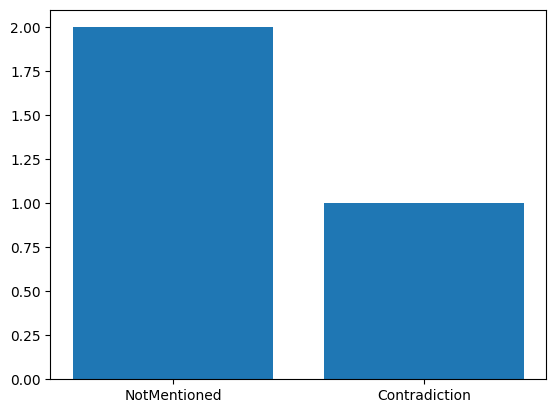

Median:  16632.0
Max :  16632
Min :  16632
Average:  16632.0


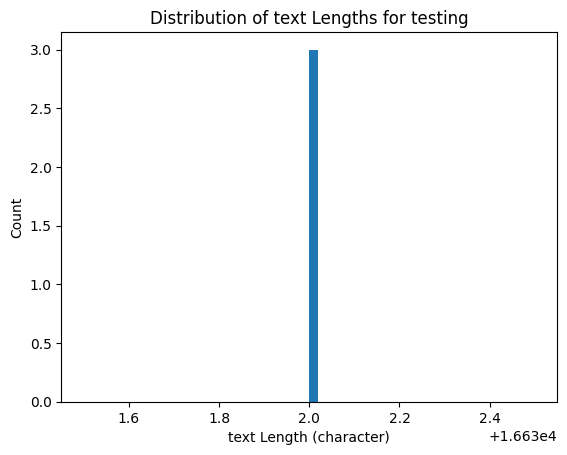

Median:  84.0
Max :  112
Min :  66
Average:  87.33333333333333


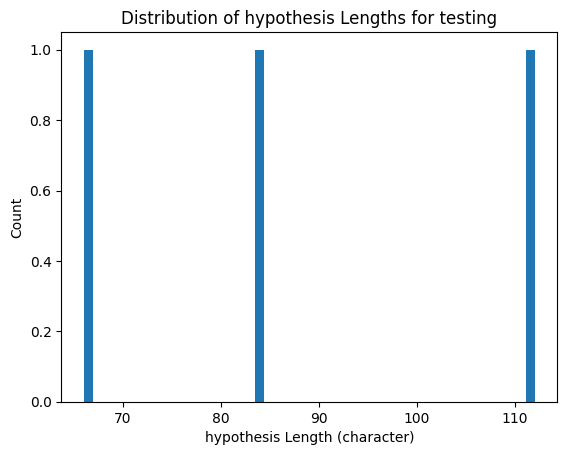

In [33]:
## ALBERT model
visalize_label(albert_wrong,'testing')
visualize_features(albert_wrong,'testing', 'text','text')
visualize_features(albert_wrong,'testing', 'hypothesis','hypothesis')




Median:  16632.0
Max :  16632
Min :  16632
Average:  16632.0


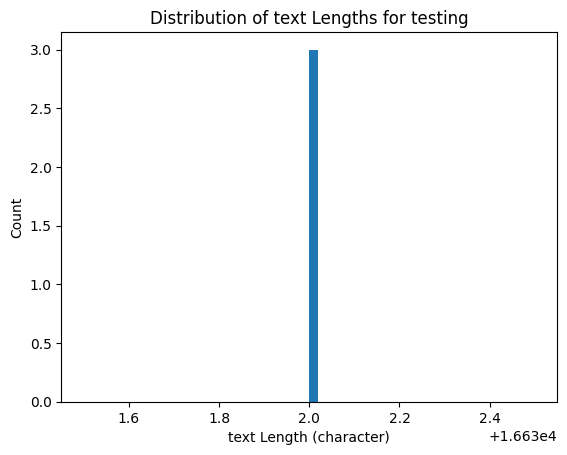

Visalizing labels for testing
labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


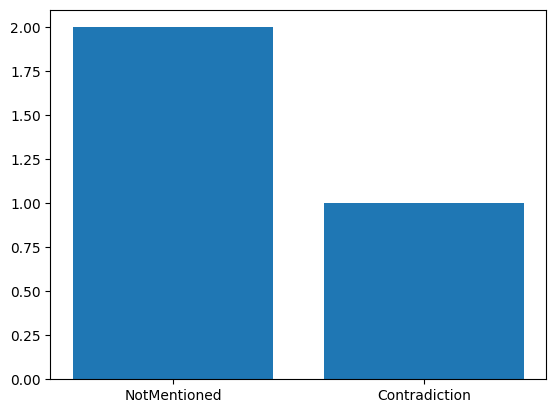

Median:  84.0
Max :  112
Min :  66
Average:  87.33333333333333


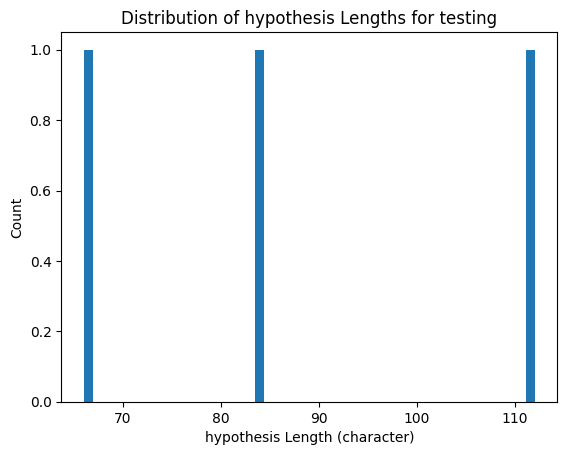

In [32]:
## DistilBERT model
visualize_features(distilbert_wrong,'testing','text','text')
visalize_label(distilbert_wrong,'testing')
visualize_features(distilbert_wrong,'testing','hypothesis','hypothesis')